# Amazon SageMaker Semantic Segmentation Algorithm - v4


In [2]:
dryrun = True
install = False

In [3]:
%%bash -s $install
source ~/git/awesome-bash-cli/abcli/.abcli/abcli.sh in_notebook

install=$1

if [[ "$install" == True ]] ; then
    cd ~/git/awesome-bash-cli
    pip3 install -e .

    cd ~/git/notebooks-and-scripts
    pip3 install -e .

    pip3 install 'sagemaker>=2,<3'
fi

🔋 gpu: not found.
🚀 abcli-7.2670.1.2023-06-aws-batch-a


In [1]:
# !cd ~/git/notebooks-and-scripts; pip3 install -e .

Obtaining file:///Users/kamangir/git/notebooks-and-scripts
  Preparing metadata (setup.py) ... done
  Attempting uninstall: notebooks-scripts
    Found existing installation: notebooks-scripts 4.173.1
    Uninstalling notebooks-scripts-4.173.1:
      Successfully uninstalled notebooks-scripts-4.173.1
  Running setup.py develop for notebooks-scripts


In [4]:
import os
os.environ["abcli_path_bash"] = "{}/git/awesome-bash-cli/bash".format(os.getenv("HOME"))

import sagemaker
from abcli import file
from abcli import fullname
from abcli import string
from abcli.modules.objects import unique_object
from abcli.modules import objects
from notebooks_and_scripts.sagemaker import role
from roofAI.logger import logger

logger.info(f"{fullname()}, built on {string.pretty_date()}")

sagemaker role: arn:aws:iam::120429650996:role/service-role/AmazonSageMaker-ExecutionRole-20240108T180012
abcli-7.2670.1-unknown, built on 01 February 2024, 19:14:59


In [5]:
# sagesemseg upload_dataset - suffix=full-v2
dataset_object_name = "pascal-voc-v1-full-v2"

if dryrun:
    # sagesemseg upload_dataset - suffix=debug-v2 --count 16
    dataset_object_name = "pascal-voc-v1-debug-v2"

logger.info(f"dataset_object_name: {dataset_object_name}")
model_object_name = unique_object("sagesemseg-model")

dataset_object_name: pascal-voc-v1-debug-v2
📂 sagesemseg-model-2024-02-01-19-14-59-00080


In [6]:
%%bash -s $dataset_object_name
source ~/git/awesome-bash-cli/abcli/.abcli/abcli.sh in_notebook

dataset_object_name=$1

abcli download filename=metadata.yaml $dataset_object_name

🔋 gpu: not found.
🚀 abcli-7.2670.1.2023-06-aws-batch-a
downloading pascal-voc-v1-debug-v2/metadata.yaml ...
download: s3://kamangir/bolt/pascal-voc-v1-debug-v2/metadata.yaml to ../../../../../storage/abcli/pascal-voc-v1-debug-v2/metadata.yaml
download completed: pascal-voc-v1-debug-v2 metadata.yaml


In [7]:
%%time
sess = sagemaker.Session()

CPU times: user 20 ms, sys: 1.29 ms, total: 21.3 ms
Wall time: 20.4 ms


In [8]:
metadata_filename = objects.path_of(object_name = dataset_object_name, filename = "metadata.yaml")
success, metadata = file.load_yaml(metadata_filename)
assert success

logger.info(f"dataset_object_name: {dataset_object_name}")

dataset_object_name: pascal-voc-v1-debug-v2


In [9]:
training_image = sagemaker.image_uris.retrieve("semantic-segmentation", sess.boto_region_name)
logger.info(f"training_image: {training_image}")

Same images used for training and inference. Defaulting to image scope: inference.
Defaulting to the only supported framework/algorithm version: 1.
Ignoring unnecessary instance type: None.
training_image: 469771592824.dkr.ecr.ca-central-1.amazonaws.com/semantic-segmentation:1


In [10]:
ss_estimator = sagemaker.estimator.Estimator(
    training_image,  # Container image URI
    role,  # Training job execution role with permissions to access our S3 bucket
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    volume_size=50,  # in GB
    max_run=360000,  # in seconds
    output_path=f"s3://kamangir/bolt/{model_object_name}",
    base_job_name=model_object_name,
    sagemaker_session=sess,
)

In [11]:
# Setup hyperparameters
ss_estimator.set_hyperparameters(
    backbone="resnet-50",  # This is the encoder. Other option is resnet-101
    algorithm="fcn",  # This is the decoder. Other options are 'psp' and 'deeplab'
    use_pretrained_model="True",  # Use the pre-trained model.
    crop_size=240,  # Size of image random crop.
    num_classes=21,  # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10,  # Number of epochs to run.
    learning_rate=0.0001,
    optimizer="rmsprop",  # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler="poly",  # Other options include 'cosine' and 'step'.
    mini_batch_size=16,  # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True,  # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=2,  # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10,  # No matter what, run these many number of epochs.
    num_training_samples=metadata["num"]["train"], # num_training_samples,  # This is a mandatory parameter, 1464 in this case.
)

In [12]:
distribution = "FullyReplicated"

data_channels = {
    "train": sagemaker.inputs.TrainingInput(
        metadata["channel"]["train"], #train_channel, 
        distribution=distribution,
    ),
    "validation": sagemaker.inputs.TrainingInput(
        metadata["channel"]["validation"], #validation_channel, 
        distribution=distribution,
    ),
    "train_annotation": sagemaker.inputs.TrainingInput(
        metadata["channel"]["train_annotation"], #train_annotation_channel, 
        distribution=distribution
    ),
    "validation_annotation": sagemaker.inputs.TrainingInput(
        metadata["channel"]["validation_annotation"], #validation_annotation_channel, 
        distribution=distribution,
    ),
    # 'label_map': metadata["channel"]["label_map"], # label_map_channel
}

In [13]:
ss_estimator.fit(data_channels, logs=True)

Creating training-job with name: sagesemseg-model-2024-02-01-19-14-59-00-2024-02-02-03-16-08-465


2024-02-02 03:16:08 Starting - Starting the training job......
2024-02-02 03:16:44 Starting - Preparing the instances for training...
2024-02-02 03:17:31 Downloading - Downloading input data..
2024-02-02 03:17:56 Downloading - Downloading the training image..................
2024-02-02 03:21:22 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Fri Feb  2 03:21:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Me

In [14]:
ss_predictor = ss_estimator.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")

Creating model with name: sagesemseg-model-2024-02-01-19-14-59-00-2024-02-02-03-29-25-762
Creating endpoint-config with name sagesemseg-model-2024-02-01-19-14-59-00-2024-02-02-03-29-25-762
Creating endpoint with name sagesemseg-model-2024-02-01-19-14-59-00-2024-02-02-03-29-25-762


---------------!

In [15]:
# As with Estimators & training jobs, we can instead attach to an existing Endpoint:
# ss_predictor = sagemaker.predictor.Predictor("ss-notebook-demo-2020-10-29-07-23-03-086")

In [16]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [17]:
filename_raw = "data/test.jpg"

!wget -O $filename_raw https://github.com/kamangir/blue-bracket/raw/main/images/helmet-1.jpg

--2024-02-01 19:37:57--  https://github.com/kamangir/blue-bracket/raw/main/images/helmet-1.jpg
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kamangir/blue-bracket/main/images/helmet-1.jpg [following]
--2024-02-01 19:37:57--  https://raw.githubusercontent.com/kamangir/blue-bracket/main/images/helmet-1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1385654 (1.3M) [image/jpeg]
Saving to: ‘data/test.jpg’

data/test.jpg       100%[===================>]   1.32M  --.-KB/s    in 0.1s    

2024-02-01 19:37:58 (8.85 MB/s) - ‘data/test.jpg’ saved [1385654/1385654]



The scale of the input image may affect the prediction results and latency, so we'll down-scale the raw image before sending it to our endpoint. You could experiment with different input resolutions (and aspect ratios) and see how the results change:

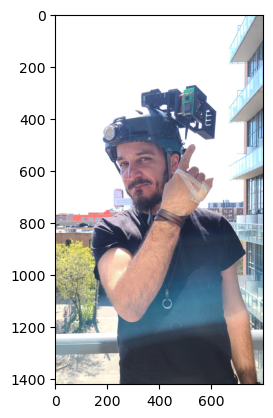

In [18]:
from matplotlib import pyplot as plt
import PIL

%matplotlib inline

filename = "data/test_resized.jpg"
width = 800

im = PIL.Image.open(filename_raw)

aspect = im.size[0] / im.size[1]

# https://stackoverflow.com/a/14351890/17619982
im.thumbnail([width, int(width / aspect)], PIL.Image.LANCZOS)
im.save(filename, "JPEG")

plt.imshow(im)
plt.show()

The endpoint accepts images in formats similar to the ones found images in the training dataset. The input `Content-Type` should be `image/jpeg`, and the output `Accept` type can be either:

- `image/png`, which produces an indexed-PNG segmentation mask as used in training: One predicted class ID per pixel... Or,
- `application/x-protobuf`, which produces a 3D matrix giving the *confidence of each class*, for each pixel.

In the SageMaker SDK, A `Predictor` has an associated **serializer** and **deserializer** which control how data gets translated to our API call, and loaded back into a Python result object.

There are pre-built [serializers](https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html) and [deserializers](https://sagemaker.readthedocs.io/en/stable/api/inference/deserializers.html) offered by the SDK, and we're free to define custom ones so long as they offer the same API.


### Basic inference - class IDs PNG

In our first example, we'll request the simple PNG response and would like to map those into pixel arrays (assigned class for each pixel)... So we'll write a custom deserializer for that:

In [19]:
from PIL import Image
import numpy as np


class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""

    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


ss_predictor.deserializer = ImageDeserializer(accept="image/png")

For the input our data is already stored as a JPEG file, so we'll use the built-in `IdentitySerializer` and feed it the file bytes:

In [20]:
ss_predictor.serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")

with open(filename, "rb") as imfile:
    imbytes = imfile.read()

# Extension exercise: Could you write a custom serializer which takes a filename as input instead?

With that configured, calling our endpoint is now simple!

In [21]:
%%time

cls_mask = ss_predictor.predict(imbytes)

print(type(cls_mask))
print(cls_mask.shape)

<class 'numpy.ndarray'>
(1422, 800)
CPU times: user 24.5 ms, sys: 0 ns, total: 24.5 ms
Wall time: 22.6 s


In [22]:
[func for func in dir(ss_predictor) if "predict" in func]

['delete_predictor', 'predict']

In [23]:
np.unique(cls_mask)

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 19,
       20], dtype=uint8)

Let us display the segmentation mask.

Since the raw value of each pixel is a small number (the class ID), we'll apply a [colormap](https://matplotlib.org/3.3.2/tutorials/colors/colormaps.html) to make it a bit more human readable and not just a black square!

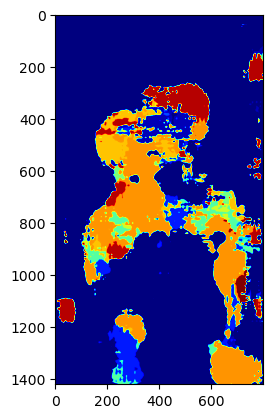

In [24]:
plt.imshow(cls_mask, cmap="jet")
plt.show()

## Delete the Endpoint

Deployed endpoints are backed by infrastructure (1x`ml.c5.xlarge` in our case, as we requested above) - so we should delete the endpoint when we're finished with it, to avoid incurring continued costs.

In [25]:
ss_predictor.delete_endpoint()

Deleting endpoint configuration with name: sagesemseg-model-2024-02-01-19-14-59-00-2024-02-02-03-29-25-762
Deleting endpoint with name: sagesemseg-model-2024-02-01-19-14-59-00-2024-02-02-03-29-25-762


## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/introduction_to_amazon_algorithms|semantic_segmentation_pascalvoc|semantic_segmentation_pascalvoc.ipynb)
